# Gage Guesser

Geospatial Data Applications
Theo Ross & Ian Van Dusen


#### Install and import packages

In [1]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U dataretrieval

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import glob
import datetime as dt

import numpy as np
import rasterio
import xarray as xr

import folium

import dataretrieval.nwis as nwis

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Map of the data set and the region

In [4]:
nisqually_loc = 46.75260766, -122.0837194
paradise_loc = 46.78, -121.75
Modis_loc = 46.783, -121.73

In [5]:
watershed = gpd.read_file('data/watershed_extent.shp')

In [6]:
nis_centerline = gpd.read_file('data/clipedp_rivline.shp')

In [7]:
fmap = folium.Map(location=[46.76,-121.9], zoom_start=11)
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(fmap)
for _, r in nis_centerline.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'color': '#1F618D'})
    geo_j.add_to(fmap)
for _, r in watershed.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'color': '#F4D03F', 'fillColor': 'clear'})
    geo_j.add_to(fmap)

folium.Marker(nisqually_loc, popup='Nisqually Gage', icon=folium.Icon(color='black', icon='tint', prefix='fa')).add_to(fmap)
folium.Marker(paradise_loc, popup='Paradise Snotel', icon=folium.Icon(color='blue', icon='asterisk', iconcolor='blue', prefix='fa')).add_to(fmap)
folium.Marker(Modis_loc, popup='Daymet', icon=folium.Icon(color='green', icon='long-arrow-down', prefix='fa')).add_to(fmap)
fmap

## Read in paradise climate data from [USDA Snotel](https://wcc.sc.egov.usda.gov/reportGenerator/view/customMultiTimeSeriesGroupByStationReport/daily/start_of_period/679:WA:SNTL%7Cid=%22%22%7Cname/2012-01-01,2022-02-22/PREC::value,PRCPMTD::value,TAVG::value,TMIN::value,TMAX::value,SMS:-2:value,SMS:-4:value,SMS:-8:value,SMS:-20:value,SNDN::value,WTEQ::value,SNWD::value,SNRR::value?fitToScreen=false)

In [8]:
paradise_path = 'data/paradiseclimate.csv'

In [9]:
pclim = pd.read_csv(paradise_path)
pclim['Date'] = pd.to_datetime(pclim['Date'])
pclim = pclim.set_index(['Date'])
pclim = pclim.loc['2012-01-01':'2021-12-31']
pclim

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values,Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values,Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Paradise (679) Real Dielectric Constant -2in (unitless) Start of Day Values
Date,,,,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,32.7,32.3,37.8,36.6,42.8,24.4,57.0,38.0,NaN
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,32.2,32.0,37.6,36.5,41.9,24.7,59.0,300.0,NaN
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,32.0,31.9,37.4,36.3,42.2,25.3,60.0,100.0,NaN
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,31.7,31.5,37.4,36.3,43.1,25.4,59.0,143.0,NaN
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,31.7,31.8,37.5,36.3,44.0,26.4,60.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,20.2,22.6,33.8,34.1,23.9,24.9,104.0,0.0,NaN
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,20.1,22.6,33.8,34.1,24.2,24.9,103.0,67.0,NaN
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,20.2,22.5,33.8,34.1,24.9,25.1,101.0,100.0,NaN


In [10]:
# read into geopandas dataframe
pclim['Surface Soil Moisture'] = pclim['Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values']
pclim['Depth Soil Moisture'] = (
                          pclim['Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values']+\
                          pclim['Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values']+\
                          pclim['Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values'])/4
df = pclim.drop(['Paradise (679) Soil Moisture Percent -2in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -4in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -8in (pct) Start of Day Values',\
                'Paradise (679) Soil Moisture Percent -20in (pct) Start of Day Values',\
                'Paradise (679) Real Dielectric Constant -2in (unitless) Start of Day Values'], axis=1)
df

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Surface Soil Moisture,Depth Soil Moisture
Date,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,42.8,24.4,57.0,38.0,32.7,26.675
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,41.9,24.7,59.0,300.0,32.2,26.525
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,42.2,25.3,60.0,100.0,32.0,26.400
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,43.1,25.4,59.0,143.0,31.7,26.300
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,44.0,26.4,60.0,0.0,31.7,26.400
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,23.9,24.9,104.0,0.0,20.2,22.625
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,24.2,24.9,103.0,67.0,20.1,22.625
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,24.9,25.1,101.0,100.0,20.2,22.600


## Read in Discharge Data

In [11]:
# specify the USGS site code for which we want data.
nisqually = '12082500' #nisqually river
puyallup = '12092000' #puyallup basin
cowlitz = '14226500' #cowlitz basin


# get instantaneous values (iv)
nisDis = nwis.get_record(sites=nisqually, service='dv', start='2012-01-01', end='2021-12-31')
nisDis

,00020_Maximum,00020_Maximum_cd,site_no,00020_Minimum,00020_Minimum_cd,00020_Mean,00020_Mean_cd,00060_Mean,00060_Mean_cd,00065_Mean,00065_Mean_cd
datetime,,,,,,,,,,,
2012-01-01 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1220.0,A,6.41,A
2012-01-02 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1010.0,A,6.10,A
2012-01-03 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,900.0,A,5.92,A
2012-01-04 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,844.0,A,5.82,A
2012-01-05 00:00:00+00:00,NaN,NaN,12082500,NaN,NaN,NaN,NaN,1010.0,A,6.09,A
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27 00:00:00+00:00,-5.3,P,12082500,-8.6,P,-6.7,P,656.0,P,4.92,P
2021-12-28 00:00:00+00:00,-1.4,P,12082500,-5.6,P,-3.5,P,610.0,P,4.85,P
2021-12-29 00:00:00+00:00,-3.4,P,12082500,-5.7,P,-4.7,P,567.0,P,4.78,P


## Combine data frames

In [12]:
df['Nisqually Discharge'] = nisDis['00060_Mean'].values
df

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Surface Soil Moisture,Depth Soil Moisture,Nisqually Discharge
Date,,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,42.8,24.4,57.0,38.0,32.7,26.675,1220.0
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,41.9,24.7,59.0,300.0,32.2,26.525,1010.0
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,42.2,25.3,60.0,100.0,32.0,26.400,900.0
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,43.1,25.4,59.0,143.0,31.7,26.300,844.0
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,44.0,26.4,60.0,0.0,31.7,26.400,1010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,23.9,24.9,104.0,0.0,20.2,22.625,656.0
2021-12-28,60.6,0.3,0.3,17.0,13.0,21.0,24.2,24.9,103.0,67.0,20.1,22.625,610.0
2021-12-29,60.9,0.1,0.1,17.0,13.0,22.0,24.9,25.1,101.0,100.0,20.2,22.600,567.0


In [13]:
df['Nisqually Discharge']

Date
2012-01-01    1220.0
2012-01-02    1010.0
2012-01-03     900.0
2012-01-04     844.0
2012-01-05    1010.0
               ...  
2021-12-27     656.0
2021-12-28     610.0
2021-12-29     567.0
2021-12-30     552.0
2021-12-31     508.0
Name: Nisqually Discharge, Length: 3653, dtype: float64

<AxesSubplot:title={'center':'Precipitation Accumulation'}, xlabel='Date', ylabel='precip accum ytd (in)'>

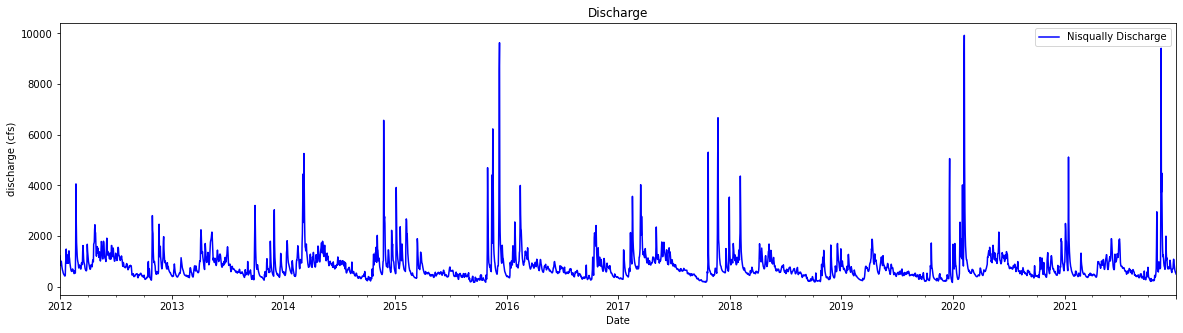

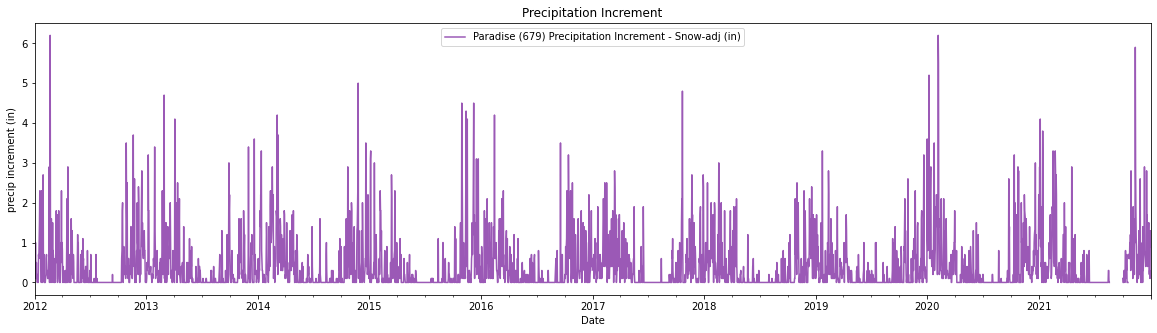

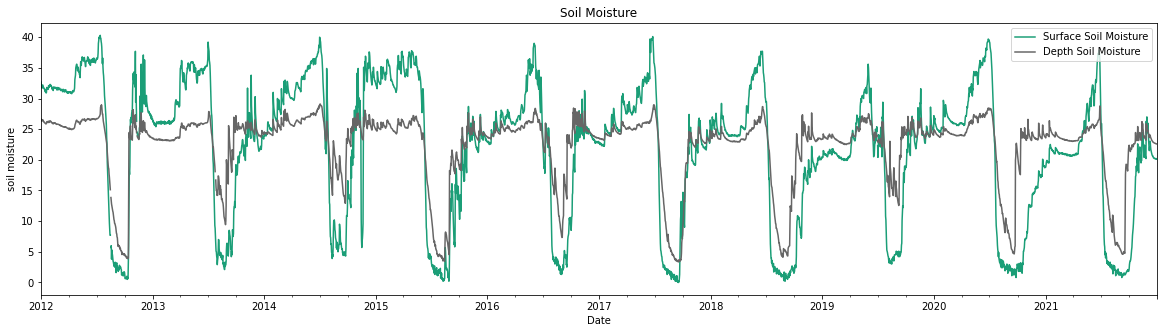

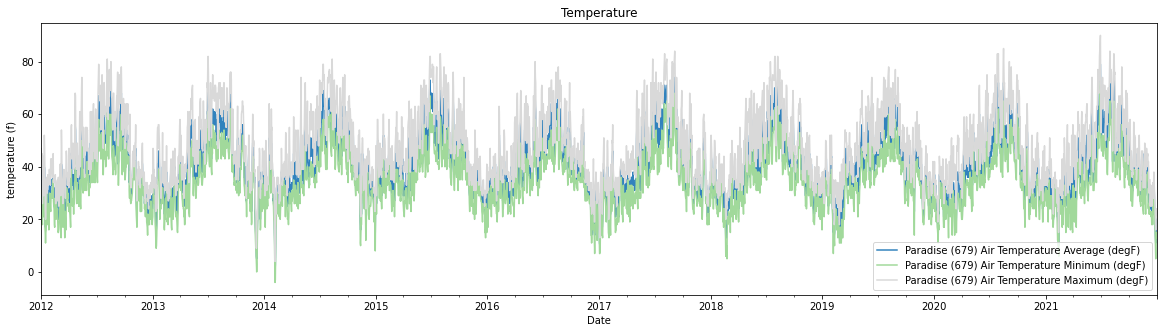

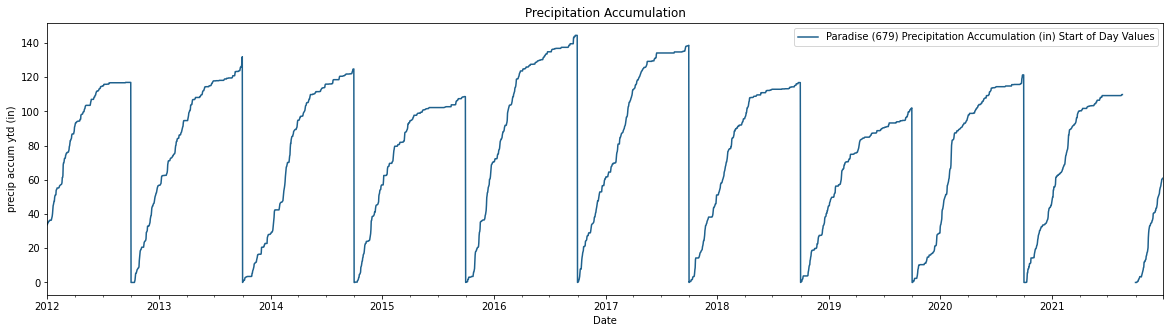

In [14]:
# Plot 2012-2021
df.loc['2012-01-01':'2021-12-31'].plot(y='Nisqually Discharge', kind ='line', figsize=(20,5), ylabel='discharge (cfs)', \
                                              title='Discharge', color='blue')
df.loc['2012-01-01':'2021-12-31'].plot(y='Paradise (679) Precipitation Increment - Snow-adj (in)', \
                                              kind ='line', figsize=(20,5), ylabel='precip increment (in)', \
                                              title='Precipitation Increment', color = '#9B59B6')
df.loc['2012-01-01':'2021-12-31'].plot(y=['Surface Soil Moisture', 'Depth Soil Moisture'], kind ='line', figsize=(20,5), ylabel='soil moisture', \
                                              title='Soil Moisture', colormap='Dark2')
df.loc['2012-01-01':'2021-12-31'].plot(y=['Paradise (679) Air Temperature Average (degF)', 'Paradise (679) Air Temperature Minimum (degF)', 'Paradise (679) Air Temperature Maximum (degF)'],\
                                       kind ='line', figsize=(20,5), ylabel='temperature (f)', \
                                              title='Temperature', colormap='tab20c')
df.loc['2012-01-01':'2021-12-31'].plot(y='Paradise (679) Precipitation Accumulation (in) Start of Day Values', \
                                              kind ='line', figsize=(20,5), ylabel='precip accum ytd (in)', \
                                              title='Precipitation Accumulation', color = '#1F618D')



In [15]:
## add month to the dataset
df['month'] = df.index.month

In [16]:
#drop the NAN values
df_cleaned = df.dropna()

In [17]:
df_cleaned

,Paradise (679) Precipitation Accumulation (in) Start of Day Values,Paradise (679) Precipitation Increment (in),Paradise (679) Precipitation Increment - Snow-adj (in),Paradise (679) Air Temperature Average (degF),Paradise (679) Air Temperature Minimum (degF),Paradise (679) Air Temperature Maximum (degF),Paradise (679) Snow Density (pct) Start of Day Values,Paradise (679) Snow Water Equivalent (in) Start of Day Values,Paradise (679) Snow Depth (in) Start of Day Values,Paradise (679) Snow Rain Ratio (unitless),Surface Soil Moisture,Depth Soil Moisture,Nisqually Discharge,month
Date,,,,,,,,,,,,,,
2012-01-01,33.8,0.8,0.8,35.0,29.0,45.0,42.8,24.4,57.0,38.0,32.7,26.675,1220.0,1
2012-01-02,34.6,0.2,0.6,37.0,31.0,47.0,41.9,24.7,59.0,300.0,32.2,26.525,1010.0,1
2012-01-03,34.8,0.1,0.1,35.0,31.0,42.0,42.2,25.3,60.0,100.0,32.0,26.400,900.0,1
2012-01-04,34.9,0.7,1.0,39.0,31.0,45.0,43.1,25.4,59.0,143.0,31.7,26.300,844.0,1
2012-01-05,35.6,0.1,0.1,26.0,19.0,32.0,44.0,26.4,60.0,0.0,31.7,26.400,1010.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-25,58.8,1.5,1.5,21.0,15.0,24.0,25.1,23.3,93.0,87.0,20.2,22.700,855.0,12
2021-12-26,60.3,0.1,0.3,14.0,11.0,18.0,23.9,24.6,103.0,300.0,20.2,22.675,745.0,12
2021-12-27,60.4,0.2,0.2,11.0,5.0,16.0,23.9,24.9,104.0,0.0,20.2,22.625,656.0,12


## Set up machine learning model to predict discharge in the basin

In [18]:
# Define feature list
feature_list =  df.columns.to_list()

In [19]:
# Compute correlation matrix
corr_matrix = df_cleaned.corr()

# Display just house value correlations
corr_matrix["Nisqually Discharge"].sort_values(ascending= False)

Nisqually Discharge                                                   1.000000
Depth Soil Moisture                                                   0.328579
Paradise (679) Precipitation Increment (in)                           0.315992
Paradise (679) Precipitation Increment - Snow-adj (in)                0.288026
Surface Soil Moisture                                                 0.193507
Paradise (679) Air Temperature Minimum (degF)                         0.180381
Paradise (679) Air Temperature Average (degF)                         0.174041
Paradise (679) Air Temperature Maximum (degF)                         0.110131
Paradise (679) Snow Density (pct) Start of Day Values                 0.063864
month                                                                 0.042942
Paradise (679) Precipitation Accumulation (in) Start of Day Values    0.001163
Paradise (679) Snow Water Equivalent (in) Start of Day Values         0.000028
Paradise (679) Snow Depth (in) Start of Day Values  

In [20]:
# Define features and labels 
X = df_cleaned[feature_list]
y = df_cleaned['Nisqually Discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [21]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [23]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

245.2745597681393

(0.0, 10000.0)

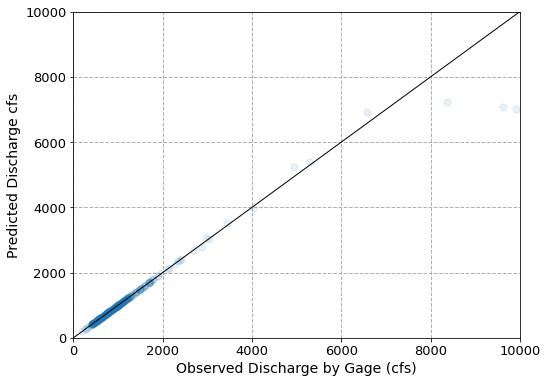

In [24]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,10000], [0, 10000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,10000)
ax.set_xlim(0,10000)

In [25]:
comp = pd.DataFrame()
comp['test_data'] = y_test
comp['predicted'] = predictions
comp['date'] = comp.index
comp = comp.sort_values(by=['date'])

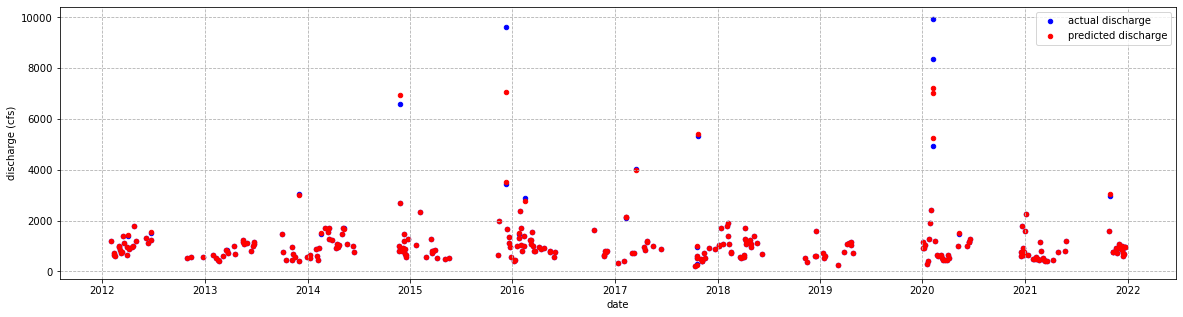

In [26]:
# Plot relationship
ax = comp.plot(kind="scatter", x="date",y="test_data", color="b", label="actual discharge", figsize=(20,5))
comp.plot(kind="scatter", x="date",y="predicted", color="r", label="predicted discharge", ax=ax)

ax.set_xlabel("date")
ax.set_ylabel("discharge (cfs)")
plt.grid(linestyle='--')
plt.show()

## Read in Data from the Daymet service
https://daymet.ornl.gov/

In [27]:
#imports some repeated
import requests
import json
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


url = "https://modis.ornl.gov/rst/api/v1/"
header = {'Accept': 'application/json'} # Use following for a csv response: header = {'Accept': 'text/csv'}

# Build time series from daymet pulls from Github


In [28]:
daymet_bands = ['prcp', 'swe','tmax','tmin']
start_dates = ['A2013001', 'A2014001', 'A2015001', 'A2016001', 'A2017001', 'A2018001']
end_dates = ['A2014001', 'A2015001', 'A2016001', 'A2017001', 'A2018001', 'A2019001']

In [29]:
response = requests.get('https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/dates')
dates = json.loads(response.text)['dates']

modis_dates = [i['modis_date'] for i in dates]
calendar_dates = [i['calendar_date'] for i in dates]

### Gathering precipitation data

In [30]:
# prcp_df = []

# for i in range(len(start_dates)):
#     start_date = start_dates[i]
#     end_date = end_dates[i]
#     dates = modis_dates[modis_dates.index(start_date):modis_dates.index(end_date)]
    
#     response = requests.get(f'https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate={start_date}&endDate={end_date}', headers=header)
#     subset = json.loads(response.text)
    
#     siteid = 'us_washington_paradise_mount_rainier_national_park'
#     prod = 'Daymet' # MODIS product
#     data_band = 'prcp' # Daytime LST band name
#     qc_band = 'QC_Day' # Daytime QC band name
#     above_below = 15 # km above/below
#     left_right = 15 # km left/right
    
#     # Initialize lists to store the returned LST and QC data
#     lstdata = []
#     qcdata = []

#     # Iterate through the list of dates and submit subset requests for each date:
#     for dt in dates:

#         # Join LST request parameters to URL string and submit request
#         lstresponse = requests.get("".join([
#             url, prod, '/' , siteid, "/subset?",
#             "band=", data_band,
#             "&startDate=", dt,
#             "&endDate=", dt,
#         ]), headers=header)

#         # Append subset data to lstdata
#         lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )

#         # Join QC request parameters to URL string and submit request
#         qcresponse = requests.get("".join([
#             url, prod, '/',
#             siteid, 
#             "/subset?",
#             "band=", data_band,
#             "&startDate=", dt,
#             "&endDate=", dt,
#         ]), headers=header)


#         # Append qc data to qcdata
#         qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )
        
#              # Convert to real dates
#     dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

#     lstdata = pd.DataFrame(lstdata, index=dates)
#     qcdata = pd.DataFrame(qcdata, index=dates)
    
#     qcvals = pd.unique(qcdata.values.ravel())
    
#     # Create empty list to store QC bit information
#     QC_Data = []

#     # Iterate through the list of 8-bit integers and populate QC table with bit definitions 
#     for integer in range(0, 256, 1):
#         bits = list(map(int, list("{0:b}".format(integer).zfill(8))))

#         # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
#         # Mandatory_QA bits description
#         if (bits[6] == 0 and bits[7] == 0):
#             Mandatory_QA = 'LST GOOD'
#         if (bits[6] == 0 and bits[7] == 1):
#             Mandatory_QA = 'LST Produced,Other Quality'
#         if (bits[6] == 1 and bits[7] == 0):
#             Mandatory_QA = 'No Pixel,clouds'
#         if (bits[6] == 1 and bits[7] == 1):
#             Mandatory_QA = 'No Pixel, Other QA'

#         # Data_Quality bits description
#         if (bits[4] == 0 and bits[5] == 0):
#             Data_Quality = 'Good Data'
#         if (bits[4] == 0 and bits[5] == 1):
#             Data_Quality = 'Other Quality'
#         if (bits[4] == 1 and bits[5] == 0):
#             Data_Quality = 'TBD'
#         if (bits[4] == 1 and bits[5] == 1):
#             Data_Quality = 'TBD'

#         # Emiss_Err bits description
#         if (bits[2] == 0 and bits[3] == 0):
#             Emiss_Err = 'Emiss Err <= .01'
#         if (bits[2] == 0 and bits[3] == 1):
#             Emiss_Err = 'Emiss Err <= .02'
#         if (bits[2] == 1 and bits[3] == 0):
#             Emiss_Err = 'Emiss Err <= .04'
#         if (bits[2] == 1 and bits[3] == 1):
#             Emiss_Err = 'Emiss Err > .04'

#         # LST_Err bits description
#         if (bits[0] == 0 and bits[1] == 0):
#             LST_Err = 'LST Err <= 1K'
#         if (bits[0] == 0 and bits[1] == 1):
#             LST_Err = 'LST Err <= 3K'
#         if (bits[0] == 1 and bits[1] == 0):
#             LST_Err = 'LST Err <= 2K'
#         if (bits[0] == 1 and bits[1] == 1):
#             LST_Err = 'LST Err > 3K' 

#         # Append this integers bit values and descriptions to list
#         QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])


#     # Convert QC bits and descriptions to pandas data frame
#     QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])

    
#     QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
    
#     QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
    
#     filter = QC_Data['Integer_Value'].tolist()
#     lstdata_filt = lstdata.mask(qcdata.isin(filter))

#     scale = json.loads(response.text)['scale']
#     lstdata_filt_scale = lstdata_filt*float(scale)

#     ncol = int(json.loads(response.text)['ncols'])
#     nrow = int(json.loads(response.text)['nrows'])


#     lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
#                                              lstdata_filt_scale.std(axis=1), 
#                                              lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
#                             columns=['mean', 'sd', 'quality'], index=dates)

#     # converting dataframe index to date time
#     lststats.index = pd.to_datetime(lststats.index)
    
#     prcp_df.append(lststats)
#     print(prcp_df)
    


## SWE data

In [31]:
# swe_df = []

# for i in range(len(start_dates)):
#     start_date = start_dates[i]
#     end_date = end_dates[i]
#     dates = modis_dates[modis_dates.index(start_date):modis_dates.index(end_date)]
    
#     response = requests.get(f'https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate={start_date}&endDate={end_date}', headers=header)
#     subset = json.loads(response.text)
    
#     siteid = 'us_washington_paradise_mount_rainier_national_park'
#     prod = 'Daymet' # MODIS product
#     data_band = 'swe' # Daytime LST band name
#     qc_band = 'QC_Day' # Daytime QC band name
#     above_below = 15 # km above/below
#     left_right = 15 # km left/right
    
#     # Initialize lists to store the returned LST and QC data
#     lstdata = []
#     qcdata = []

#     # Iterate through the list of dates and submit subset requests for each date:
#     for dt in dates:

#         # Join LST request parameters to URL string and submit request
#         lstresponse = requests.get("".join([
#             url, prod, '/' , siteid, "/subset?",
#             "band=", data_band,
#             "&startDate=", dt,
#             "&endDate=", dt,
#         ]), headers=header)

#         # Append subset data to lstdata
#         lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )

#         # Join QC request parameters to URL string and submit request
#         qcresponse = requests.get("".join([
#             url, prod, '/',
#             siteid, 
#             "/subset?",
#             "band=", data_band,
#             "&startDate=", dt,
#             "&endDate=", dt,
#         ]), headers=header)


#         # Append qc data to qcdata
#         qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )
        
#              # Convert to real dates
#     dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

#     lstdata = pd.DataFrame(lstdata, index=dates)
#     qcdata = pd.DataFrame(qcdata, index=dates)
    
#     qcvals = pd.unique(qcdata.values.ravel())
    
#     # Create empty list to store QC bit information
#     QC_Data = []

#     # Iterate through the list of 8-bit integers and populate QC table with bit definitions 
#     for integer in range(0, 256, 1):
#         bits = list(map(int, list("{0:b}".format(integer).zfill(8))))

#         # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
#         # Mandatory_QA bits description
#         if (bits[6] == 0 and bits[7] == 0):
#             Mandatory_QA = 'LST GOOD'
#         if (bits[6] == 0 and bits[7] == 1):
#             Mandatory_QA = 'LST Produced,Other Quality'
#         if (bits[6] == 1 and bits[7] == 0):
#             Mandatory_QA = 'No Pixel,clouds'
#         if (bits[6] == 1 and bits[7] == 1):
#             Mandatory_QA = 'No Pixel, Other QA'

#         # Data_Quality bits description
#         if (bits[4] == 0 and bits[5] == 0):
#             Data_Quality = 'Good Data'
#         if (bits[4] == 0 and bits[5] == 1):
#             Data_Quality = 'Other Quality'
#         if (bits[4] == 1 and bits[5] == 0):
#             Data_Quality = 'TBD'
#         if (bits[4] == 1 and bits[5] == 1):
#             Data_Quality = 'TBD'

#         # Emiss_Err bits description
#         if (bits[2] == 0 and bits[3] == 0):
#             Emiss_Err = 'Emiss Err <= .01'
#         if (bits[2] == 0 and bits[3] == 1):
#             Emiss_Err = 'Emiss Err <= .02'
#         if (bits[2] == 1 and bits[3] == 0):
#             Emiss_Err = 'Emiss Err <= .04'
#         if (bits[2] == 1 and bits[3] == 1):
#             Emiss_Err = 'Emiss Err > .04'

#         # LST_Err bits description
#         if (bits[0] == 0 and bits[1] == 0):
#             LST_Err = 'LST Err <= 1K'
#         if (bits[0] == 0 and bits[1] == 1):
#             LST_Err = 'LST Err <= 3K'
#         if (bits[0] == 1 and bits[1] == 0):
#             LST_Err = 'LST Err <= 2K'
#         if (bits[0] == 1 and bits[1] == 1):
#             LST_Err = 'LST Err > 3K' 

#         # Append this integers bit values and descriptions to list
#         QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])


#     # Convert QC bits and descriptions to pandas data frame
#     QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])

    
#     QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
    
#     QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
    
#     filter = QC_Data['Integer_Value'].tolist()
#     lstdata_filt = lstdata.mask(qcdata.isin(filter))

#     scale = json.loads(response.text)['scale']
#     lstdata_filt_scale = lstdata_filt*float(scale)

#     ncol = int(json.loads(response.text)['ncols'])
#     nrow = int(json.loads(response.text)['nrows'])


#     lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
#                                              lstdata_filt_scale.std(axis=1), 
#                                              lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
#                             columns=['mean', 'sd', 'quality'], index=dates)

#         # converting dataframe index to date time
#     lststats.index = pd.to_datetime(lststats.index)
    
#     swe_df.append(lststats)
#     print(swe_df)
    
    

## tmax data

In [32]:
# tmax_df = []

# for i in range(len(start_dates)):
#     start_date = start_dates[i]
#     end_date = end_dates[i]
#     dates = modis_dates[modis_dates.index(start_date):modis_dates.index(end_date)]
    
#     response = requests.get(f'https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate={start_date}&endDate={end_date}', headers=header)
#     subset = json.loads(response.text)
    
#     siteid = 'us_washington_paradise_mount_rainier_national_park'
#     prod = 'Daymet' # MODIS product
#     data_band = 'tmax' # Daytime LST band name
#     qc_band = 'QC_Day' # Daytime QC band name
#     above_below = 15 # km above/below
#     left_right = 15 # km left/right
    
#     # Initialize lists to store the returned LST and QC data
#     lstdata = []
#     qcdata = []

#     # Iterate through the list of dates and submit subset requests for each date:
#     for dt in dates:

#         # Join LST request parameters to URL string and submit request
#         lstresponse = requests.get("".join([
#             url, prod, '/' , siteid, "/subset?",
#             "band=", data_band,
#             "&startDate=", dt,
#             "&endDate=", dt,
#         ]), headers=header)

#         # Append subset data to lstdata
#         lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )

#         # Join QC request parameters to URL string and submit request
#         qcresponse = requests.get("".join([
#             url, prod, '/',
#             siteid, 
#             "/subset?",
#             "band=", data_band,
#             "&startDate=", dt,
#             "&endDate=", dt,
#         ]), headers=header)


#         # Append qc data to qcdata
#         qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )
        
#              # Convert to real dates
#     dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

#     lstdata = pd.DataFrame(lstdata, index=dates)
#     qcdata = pd.DataFrame(qcdata, index=dates)
    
#     qcvals = pd.unique(qcdata.values.ravel())
    
#     # Create empty list to store QC bit information
#     QC_Data = []

#     # Iterate through the list of 8-bit integers and populate QC table with bit definitions 
#     for integer in range(0, 256, 1):
#         bits = list(map(int, list("{0:b}".format(integer).zfill(8))))

#         # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
#         # Mandatory_QA bits description
#         if (bits[6] == 0 and bits[7] == 0):
#             Mandatory_QA = 'LST GOOD'
#         if (bits[6] == 0 and bits[7] == 1):
#             Mandatory_QA = 'LST Produced,Other Quality'
#         if (bits[6] == 1 and bits[7] == 0):
#             Mandatory_QA = 'No Pixel,clouds'
#         if (bits[6] == 1 and bits[7] == 1):
#             Mandatory_QA = 'No Pixel, Other QA'

#         # Data_Quality bits description
#         if (bits[4] == 0 and bits[5] == 0):
#             Data_Quality = 'Good Data'
#         if (bits[4] == 0 and bits[5] == 1):
#             Data_Quality = 'Other Quality'
#         if (bits[4] == 1 and bits[5] == 0):
#             Data_Quality = 'TBD'
#         if (bits[4] == 1 and bits[5] == 1):
#             Data_Quality = 'TBD'

#         # Emiss_Err bits description
#         if (bits[2] == 0 and bits[3] == 0):
#             Emiss_Err = 'Emiss Err <= .01'
#         if (bits[2] == 0 and bits[3] == 1):
#             Emiss_Err = 'Emiss Err <= .02'
#         if (bits[2] == 1 and bits[3] == 0):
#             Emiss_Err = 'Emiss Err <= .04'
#         if (bits[2] == 1 and bits[3] == 1):
#             Emiss_Err = 'Emiss Err > .04'

#         # LST_Err bits description
#         if (bits[0] == 0 and bits[1] == 0):
#             LST_Err = 'LST Err <= 1K'
#         if (bits[0] == 0 and bits[1] == 1):
#             LST_Err = 'LST Err <= 3K'
#         if (bits[0] == 1 and bits[1] == 0):
#             LST_Err = 'LST Err <= 2K'
#         if (bits[0] == 1 and bits[1] == 1):
#             LST_Err = 'LST Err > 3K' 

#         # Append this integers bit values and descriptions to list
#         QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])


#     # Convert QC bits and descriptions to pandas data frame
#     QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])

    
#     QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
    
#     QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
    
#     filter = QC_Data['Integer_Value'].tolist()
#     lstdata_filt = lstdata.mask(qcdata.isin(filter))

#     scale = json.loads(response.text)['scale']
#     lstdata_filt_scale = lstdata_filt*float(scale)

#     ncol = int(json.loads(response.text)['ncols'])
#     nrow = int(json.loads(response.text)['nrows'])


#     lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
#                                              lstdata_filt_scale.std(axis=1), 
#                                              lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
#                             columns=['mean', 'sd', 'quality'], index=dates)

#         # converting dataframe index to date time
#     lststats.index = pd.to_datetime(lststats.index)
    
#     tmax_df.append(lststats)
#     print(tmax_df)
    


## tmin data

In [33]:
# tmin_df = []

# for i in range(len(start_dates)):
#     start_date = start_dates[i]
#     end_date = end_dates[i]
#     dates = modis_dates[modis_dates.index(start_date):modis_dates.index(end_date)]
    
#     response = requests.get(f'https://modis.ornl.gov/rst/api/v1/Daymet/us_washington_paradise_mount_rainier_national_park/subset?band=prcp&startDate={start_date}&endDate={end_date}', headers=header)
#     subset = json.loads(response.text)
    
#     siteid = 'us_washington_paradise_mount_rainier_national_park'
#     prod = 'Daymet' # MODIS product
#     data_band = 'tmin' # Daytime LST band name
#     qc_band = 'QC_Day' # Daytime QC band name
#     above_below = 15 # km above/below
#     left_right = 15 # km left/right
    
#     # Initialize lists to store the returned LST and QC data
#     lstdata = []
#     qcdata = []

#     # Iterate through the list of dates and submit subset requests for each date:
#     for dt in dates:

#         # Join LST request parameters to URL string and submit request
#         lstresponse = requests.get("".join([
#             url, prod, '/' , siteid, "/subset?",
#             "band=", data_band,
#             "&startDate=", dt,
#             "&endDate=", dt,
#         ]), headers=header)

#         # Append subset data to lstdata
#         lstdata.append( json.loads(lstresponse.text)['subset'][0]['data'] )

#         # Join QC request parameters to URL string and submit request
#         qcresponse = requests.get("".join([
#             url, prod, '/',
#             siteid, 
#             "/subset?",
#             "band=", data_band,
#             "&startDate=", dt,
#             "&endDate=", dt,
#         ]), headers=header)


#         # Append qc data to qcdata
#         qcdata.append( json.loads(qcresponse.text)['subset'][0]['data'] )
        
#              # Convert to real dates
#     dates = [(datetime.datetime(int(date[1:5]), 1, 1) + datetime.timedelta(int(date[5:]))).strftime('%Y-%m-%d') for date in dates]

#     lstdata = pd.DataFrame(lstdata, index=dates)
#     qcdata = pd.DataFrame(qcdata, index=dates)
    
#     qcvals = pd.unique(qcdata.values.ravel())
    
#     # Create empty list to store QC bit information
#     QC_Data = []

#     # Iterate through the list of 8-bit integers and populate QC table with bit definitions 
#     for integer in range(0, 256, 1):
#         bits = list(map(int, list("{0:b}".format(integer).zfill(8))))

#         # Describe each of the bits. Remember bits are big endian so bits[7] == bit 0
#         # Mandatory_QA bits description
#         if (bits[6] == 0 and bits[7] == 0):
#             Mandatory_QA = 'LST GOOD'
#         if (bits[6] == 0 and bits[7] == 1):
#             Mandatory_QA = 'LST Produced,Other Quality'
#         if (bits[6] == 1 and bits[7] == 0):
#             Mandatory_QA = 'No Pixel,clouds'
#         if (bits[6] == 1 and bits[7] == 1):
#             Mandatory_QA = 'No Pixel, Other QA'

#         # Data_Quality bits description
#         if (bits[4] == 0 and bits[5] == 0):
#             Data_Quality = 'Good Data'
#         if (bits[4] == 0 and bits[5] == 1):
#             Data_Quality = 'Other Quality'
#         if (bits[4] == 1 and bits[5] == 0):
#             Data_Quality = 'TBD'
#         if (bits[4] == 1 and bits[5] == 1):
#             Data_Quality = 'TBD'

#         # Emiss_Err bits description
#         if (bits[2] == 0 and bits[3] == 0):
#             Emiss_Err = 'Emiss Err <= .01'
#         if (bits[2] == 0 and bits[3] == 1):
#             Emiss_Err = 'Emiss Err <= .02'
#         if (bits[2] == 1 and bits[3] == 0):
#             Emiss_Err = 'Emiss Err <= .04'
#         if (bits[2] == 1 and bits[3] == 1):
#             Emiss_Err = 'Emiss Err > .04'

#         # LST_Err bits description
#         if (bits[0] == 0 and bits[1] == 0):
#             LST_Err = 'LST Err <= 1K'
#         if (bits[0] == 0 and bits[1] == 1):
#             LST_Err = 'LST Err <= 3K'
#         if (bits[0] == 1 and bits[1] == 0):
#             LST_Err = 'LST Err <= 2K'
#         if (bits[0] == 1 and bits[1] == 1):
#             LST_Err = 'LST Err > 3K' 

#         # Append this integers bit values and descriptions to list
#         QC_Data.append([integer] + bits + [Mandatory_QA, Data_Quality, Emiss_Err, LST_Err])


#     # Convert QC bits and descriptions to pandas data frame
#     QC_Data = pd.DataFrame(QC_Data, columns=['Integer_Value', 'Bit7', 'Bit6', 'Bit5', 'Bit4', 'Bit3', 'Bit2', 'Bit1', 'Bit0', 'Mandatory_QA', 'Data_Quality', 'Emiss_Err', 'LST_Err'])

    
#     QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin(qcvals)]
    
#     QC_Data = QC_Data.loc[QC_Data['Integer_Value'].isin([2,3]) | ((QC_Data['Bit0'] == 1) & (QC_Data['Bit1'] == 0) & (QC_Data['Bit6'] != 0))]
    
#     filter = QC_Data['Integer_Value'].tolist()
#     lstdata_filt = lstdata.mask(qcdata.isin(filter))

#     scale = json.loads(response.text)['scale']
#     lstdata_filt_scale = lstdata_filt*float(scale)

#     ncol = int(json.loads(response.text)['ncols'])
#     nrow = int(json.loads(response.text)['nrows'])


#     lststats = pd.DataFrame(np.column_stack([lstdata_filt_scale.mean(axis=1), 
#                                              lstdata_filt_scale.std(axis=1), 
#                                              lstdata_filt_scale.apply(lambda row: (float(row.count())/(ncol*nrow))*100, axis=1)]), 
#                             columns=['mean', 'sd', 'quality'], index=dates)

#         # converting dataframe index to date time
#     lststats.index = pd.to_datetime(lststats.index)
    
#     tmin_df.append(lststats)
#     print(tmin_df)
    

#### exporting the data sets to csv so we do not have to run the code again..
computaionally expensive

In [34]:
# prec_df = pd.concat(prcp_df)
# prec_df.to_csv('data/prec_df.csv')

In [35]:
# swe_df = pd.concat(swe_df)
# swe_df.to_csv('data/swe_df.csv')

In [36]:
# tmax_df = pd.concat(tmax_df)
# tmax_df.to_csv('data/tmax_df.csv')

In [37]:
# tmin_df = pd.concat(tmin_df)
# tmin_df.to_csv('data/tmin_df.csv')

In [38]:
daymet_df = pd.DataFrame()

In [39]:
prec_data = pd.read_csv('data/prec_df.csv')
swe_data = pd.read_csv('data/swe_df.csv')
tmax_data = pd.read_csv('data/tmax_df.csv')
tmin_data = pd.read_csv('data/tmin_df.csv')

In [40]:
daymet_df['prec_data'] = prec_data['mean']
daymet_df['swe_data'] = swe_data['mean']
daymet_df['tmax_data'] = tmax_data['mean']
daymet_df['tmin_data'] = tmin_data['mean']
daymet_df['date'] = prec_data['Unnamed: 0']

In [41]:
daymet_df['date'] = pd.to_datetime(daymet_df['date'])
daymet_df = daymet_df.set_index('date')

## Adding Discharge data to train Daymet

In [42]:
# Strangling with dates as always
nisDis['date'] = nisDis.index
nisDis['date'] = pd.to_datetime(nisDis['date'], utc = False)
nisDis['date'] = nisDis['date'].astype(str)
dates = nisDis['date'].to_list()
new_dates = []
for date in dates:
    new_date = date[0:10]
    new_dates.append(new_date)
nisDis['date'] = new_dates

In [43]:
discharge = pd.DataFrame()
discharge['date'] = nisDis['date']
discharge['nisqually_discharge'] = nisDis['00060_Mean']
discharge.reset_index(drop=True, inplace=True)
discharge['date'] = pd.to_datetime(discharge['date'])
discharge.set_index('date')

,nisqually_discharge
date,
2012-01-01,1220.0
2012-01-02,1010.0
2012-01-03,900.0
2012-01-04,844.0
2012-01-05,1010.0
...,...
2021-12-27,656.0
2021-12-28,610.0
2021-12-29,567.0


In [44]:
daymet_df = daymet_df.merge(discharge, on='date')
daymet_df = daymet_df.set_index('date')
daymet_df

,prec_data,swe_data,tmax_data,tmin_data,nisqually_discharge
date,,,,,
2013-01-02,0.000000,86.364815,1.876875,-6.503580,413.0
2013-01-03,0.000000,85.462469,4.701358,-3.813457,404.0
2013-01-04,11.757654,84.381481,4.614568,-3.379877,423.0
2013-01-05,7.507901,82.577037,2.696420,-1.602469,426.0
2013-01-06,11.034198,81.034321,1.551852,-2.218889,425.0
...,...,...,...,...,...
2018-12-28,7.342593,145.481358,-1.446420,-5.261358,635.0
2018-12-29,29.758889,152.221852,0.955309,-5.120123,1010.0
2018-12-30,32.924568,152.353951,1.851481,-2.797901,1500.0


In [45]:
## add month to the dataset
daymet_df['month'] = daymet_df.index.month

In [46]:
daymet_df

,prec_data,swe_data,tmax_data,tmin_data,nisqually_discharge,month
date,,,,,,
2013-01-02,0.000000,86.364815,1.876875,-6.503580,413.0,1
2013-01-03,0.000000,85.462469,4.701358,-3.813457,404.0,1
2013-01-04,11.757654,84.381481,4.614568,-3.379877,423.0,1
2013-01-05,7.507901,82.577037,2.696420,-1.602469,426.0,1
2013-01-06,11.034198,81.034321,1.551852,-2.218889,425.0,1
...,...,...,...,...,...,...
2018-12-28,7.342593,145.481358,-1.446420,-5.261358,635.0,12
2018-12-29,29.758889,152.221852,0.955309,-5.120123,1010.0,12
2018-12-30,32.924568,152.353951,1.851481,-2.797901,1500.0,12


## Visualizing and Plotting the data

<AxesSubplot:title={'center':'Min Temp'}, xlabel='date', ylabel='min temperature (C˚)'>

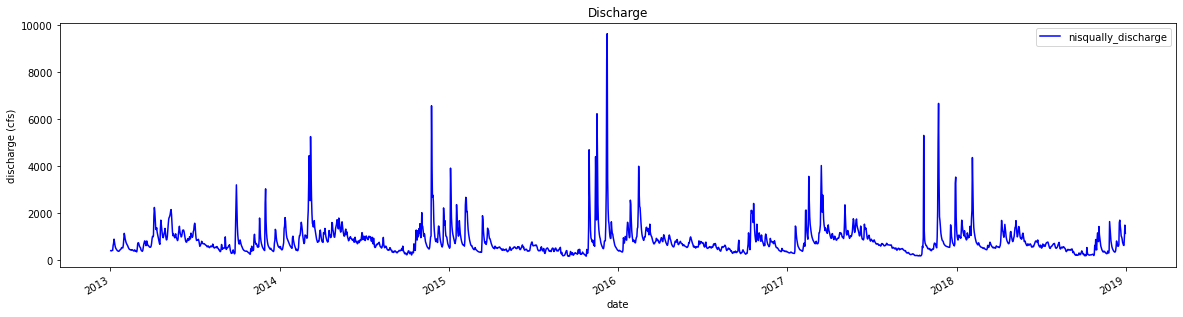

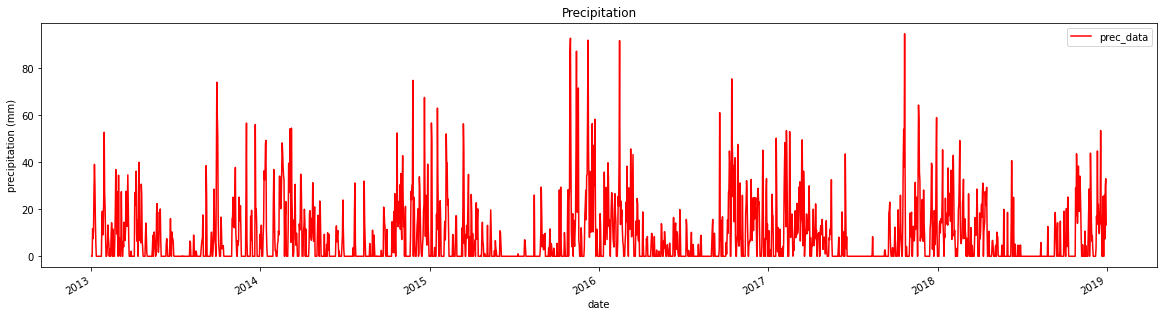

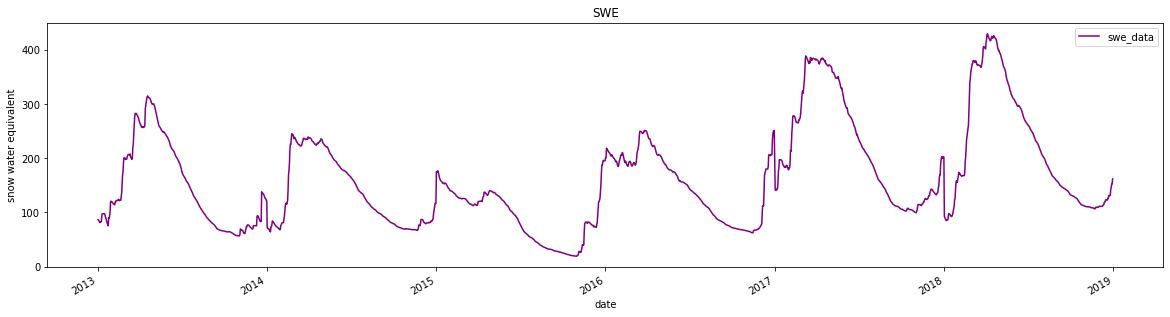

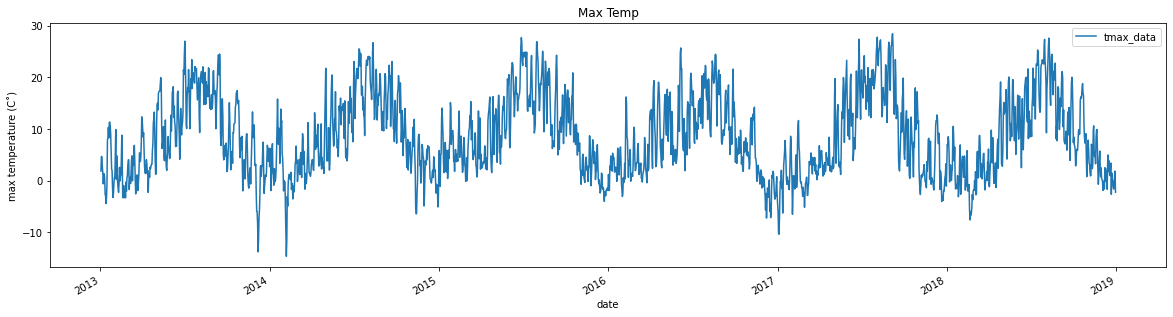

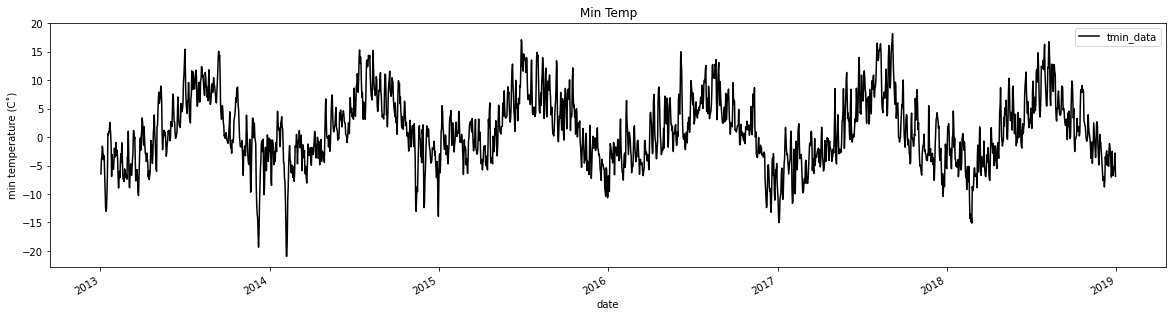

In [47]:
# Plot 2013-2018
daymet_df.loc['2013-01-01':'2018-12-31'].plot(y='nisqually_discharge', kind ='line', figsize=(20,5), ylabel='discharge (cfs)', \
                                              title='Discharge', color='blue')
daymet_df.loc['2013-01-01':'2018-12-31'].plot(y='prec_data', kind ='line', figsize=(20,5), ylabel='precipitation (mm)', \
                                              title='Precipitation', color='red')
daymet_df.loc['2013-01-01':'2018-12-31'].plot(y='swe_data', kind ='line', figsize=(20,5), ylabel='snow water equivalent', \
                                              title='SWE', color='purple')
daymet_df.loc['2013-01-01':'2018-12-31'].plot(y='tmax_data', kind ='line', figsize=(20,5), ylabel='max temperature (C˚)', \
                                              title='Max Temp')
daymet_df.loc['2013-01-01':'2018-12-31'].plot(y='tmin_data', kind ='line', figsize=(20,5), ylabel='min temperature (C˚)', \
                                              title='Min Temp', color = 'black')

## Machine Learning Model for Daymet data

In [48]:
daymet_cleaned = daymet_df.dropna()

In [49]:
# Define feature list
feature_list =  ['prec_data', 'swe_data', 'tmax_data', 'tmin_data', 'month']

In [50]:
# Compute correlation matrix
corr_matrix = daymet_cleaned.corr()

# Display just house value correlations
corr_matrix["nisqually_discharge"].sort_values(ascending= False)

nisqually_discharge    1.000000
prec_data              0.582417
swe_data               0.191733
tmin_data             -0.101449
month                 -0.106460
tmax_data             -0.145459
Name: nisqually_discharge, dtype: float64

In [51]:
X = daymet_cleaned[feature_list]
y = daymet_cleaned['nisqually_discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [52]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [53]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [54]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

368.7838551167186

(0.0, 10000.0)

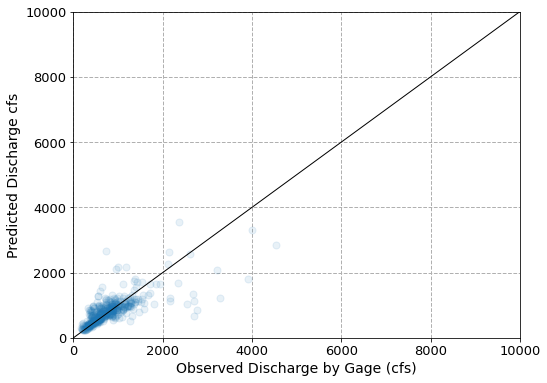

In [55]:
import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,10000], [0, 10000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,10000)
ax.set_xlim(0,10000)

In [56]:
comp = pd.DataFrame()
comp['test_data'] = y_test
comp['predicted'] = predictions
comp['date_col'] = comp.index
comp = comp.sort_values(by=['date_col'])

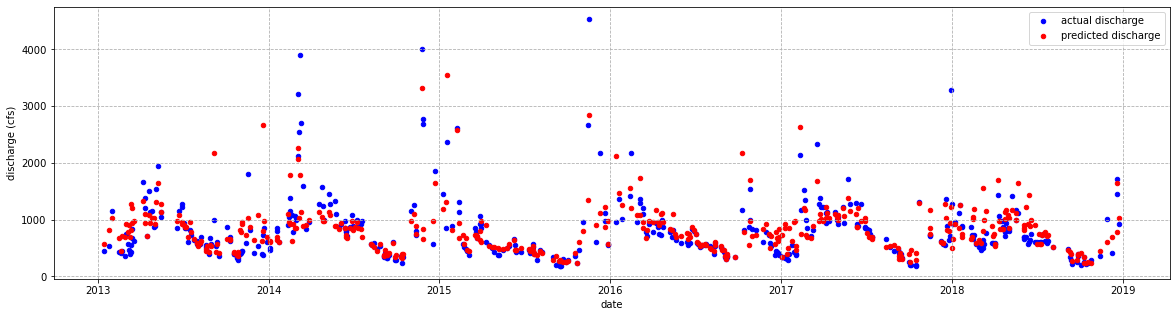

In [57]:
# Plot relationship
ax = comp.plot(kind="scatter", x="date_col",y="test_data", color="b", label="actual discharge", figsize=(20,5))
comp.plot(kind="scatter", x="date_col",y="predicted", color="r", label="predicted discharge", ax=ax)

ax.set_xlabel("date")
ax.set_ylabel("discharge (cfs)")
plt.grid(linestyle='--')
plt.show()

### Read snow and temperature data from MODIS

In [58]:
snow = pd.read_csv('data/MODIS/snow_cover.csv')
temp = pd.read_csv('data/MODIS/land_surface_temp_K.csv')

In [59]:
# Get hourly dates as list
modis_dates = snow['date'].to_list()
modis_dates = [str(date) for date in modis_dates]

In [60]:
# Reformat dates and convert to datetime objects
new_dates = []
for date in modis_dates:
    new_date = f'{date[0:4]}-{date[5:7]}-{date[8:10]}'
    new_dates.append(new_date)
new_dates   

snow['date'] = new_dates
snow['date']= pd.to_datetime(snow['date'])
snow = snow.set_index('date')

temp['date'] = new_dates
temp['date']= pd.to_datetime(temp['date'])
temp = temp.set_index('date')

# Convert Kelvin to Farenheight (MODIS has scale factor of 0.02)
temp = temp.assign(fahrenheit = lambda x: ((x['LST_Day_1km']*0.02)-273.15)*(9/5)+32)

### Read GPM precipitation data

In [61]:
prec_hourly = pd.read_csv('data/MODIS/precipitation.csv')

In [62]:
# Get hourly dates as list
gpm_dates = prec_hourly['date'].to_list()
gpm_dates = [str(date) for date in gpm_dates]

In [63]:
# Convert to date to datetime objects
new_dates = []
for date in gpm_dates:
    new_date = f'{date[0:4]}-{date[4:6]}-{date[6:8]} {date[8:10]}:{date[10:12]}:00'
    new_dates.append(new_date)
prec_hourly['date'] = new_dates
prec_hourly['date']= pd.to_datetime(prec_hourly['date'])
prec_hourly = prec_hourly.set_index('date')

In [64]:
# Resample to daily intervals
prec_daily = prec_hourly.resample('D').sum()

### Create new dataframe with all satellite variables

In [65]:
satellite = pd.DataFrame()
satellite['snow'] = snow['NDSI_Snow_Cover']
satellite['temp'] = temp['fahrenheit']
satellite['prec'] = prec_daily['precipitationCal']

In [66]:
# Strangling with dates as always
nisDis['date'] = nisDis.index
nisDis['date'] = pd.to_datetime(nisDis['date'], utc = False)
nisDis['date'] = nisDis['date'].astype(str)
dates = nisDis['date'].to_list()
new_dates = []
for date in dates:
    new_date = date[0:10]
    new_dates.append(new_date)
nisDis['date'] = new_dates

In [67]:
discharge = pd.DataFrame()
discharge['date'] = nisDis['date']
discharge['nisqually_discharge'] = nisDis['00060_Mean']
discharge.reset_index(drop=True, inplace=True)
discharge['date'] = pd.to_datetime(discharge['date'])
discharge.set_index('date')

,nisqually_discharge
date,
2012-01-01,1220.0
2012-01-02,1010.0
2012-01-03,900.0
2012-01-04,844.0
2012-01-05,1010.0
...,...
2021-12-27,656.0
2021-12-28,610.0
2021-12-29,567.0


In [68]:
satellite = satellite.merge(discharge, on='date')
satellite = satellite.set_index('date')
satellite['month'] = satellite.index.month
satellite

,snow,temp,prec,nisqually_discharge,month
date,,,,,
2013-01-01,56.669666,31.283200,25.122626,424.0,1
2013-01-02,52.070299,34.500663,0.235298,413.0,1
2013-01-03,51.463661,34.984130,0.010412,404.0,1
2013-01-04,65.101677,25.856654,11.616317,423.0,1
2013-01-05,NaN,NaN,159.500557,426.0,1
...,...,...,...,...,...
2021-12-27,42.476682,1.240611,45.353518,656.0,12
2021-12-28,NaN,NaN,96.939873,610.0,12
2021-12-29,61.435763,4.933996,0.726814,567.0,12


<AxesSubplot:title={'center':'Temperature'}, xlabel='date', ylabel='temperature (f)'>

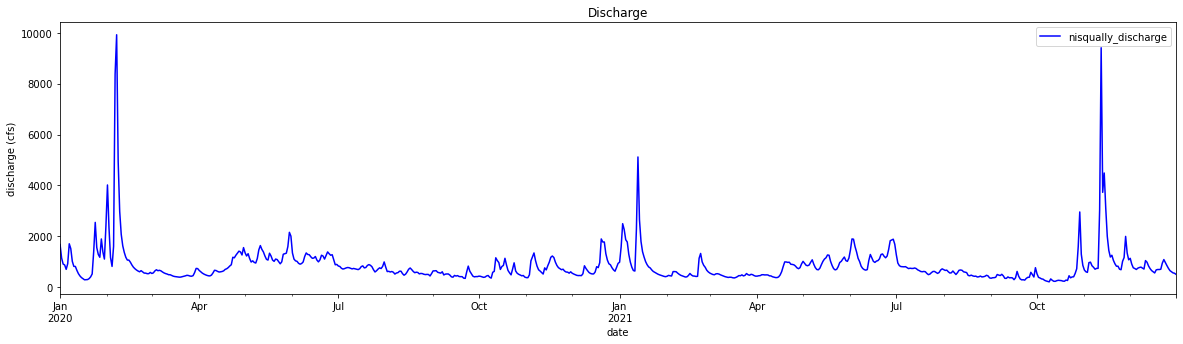

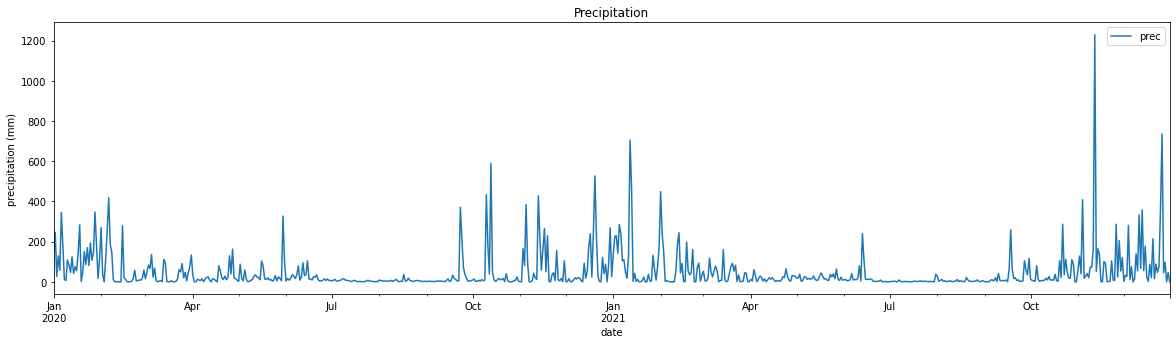

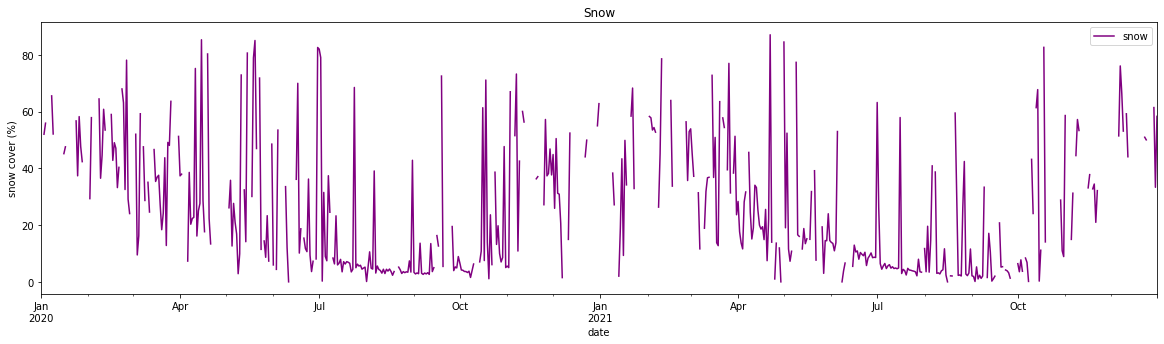

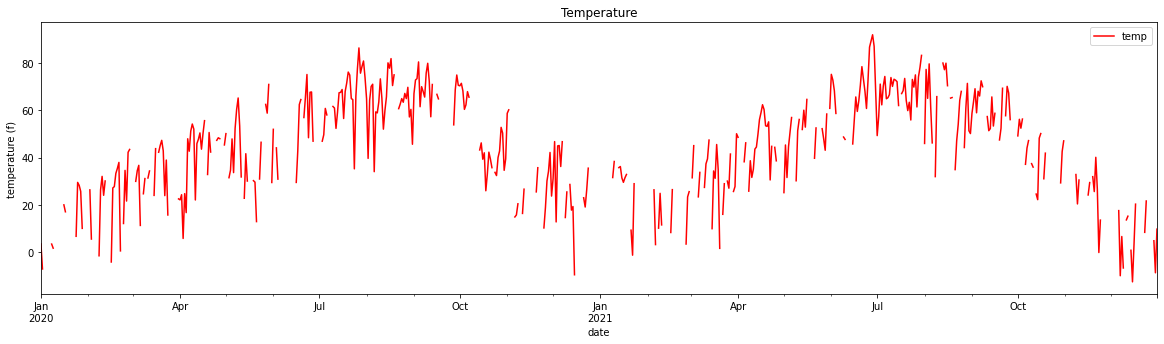

In [69]:
# Plot 2020-2021
satellite.loc['2020-01-01':'2021-12-31'].plot(y='nisqually_discharge', kind ='line', figsize=(20,5), ylabel='discharge (cfs)', \
                                              title='Discharge', color='blue')
satellite.loc['2020-01-01':'2021-12-31'].plot(y='prec', kind ='line', figsize=(20,5), ylabel='precipitation (mm)', \
                                              title='Precipitation')
satellite.loc['2020-01-01':'2021-12-31'].plot(y='snow', kind ='line', figsize=(20,5), ylabel='snow cover (%)', title='Snow', \
                                              color='purple')
satellite.loc['2020-01-01':'2021-12-31'].plot(y='temp', kind ='line', figsize=(20,5), ylabel='temperature (f)', title='Temperature', \
                                              color='red')


## Set up machine learning model to predict discharge using satellite data

In [70]:
satellite_cleaned = satellite.dropna()

In [71]:
satellite_cleaned

,snow,temp,prec,nisqually_discharge,month
date,,,,,
2013-01-01,56.669666,31.283200,25.122626,424.0,1
2013-01-02,52.070299,34.500663,0.235298,413.0,1
2013-01-03,51.463661,34.984130,0.010412,404.0,1
2013-01-04,65.101677,25.856654,11.616317,423.0,1
2013-01-06,39.286975,34.226659,3.846788,425.0,1
...,...,...,...,...,...
2021-12-24,50.053224,21.695956,75.993609,971.0,12
2021-12-27,42.476682,1.240611,45.353518,656.0,12
2021-12-29,61.435763,4.933996,0.726814,567.0,12


In [72]:
# Define feature list
feature_list =  ['snow', 'temp', 'prec', 'month']

In [73]:
# Compute correlation matrix
corr_matrix = satellite_cleaned.corr()

# Display just house value correlations
corr_matrix["nisqually_discharge"].sort_values(ascending= False)

nisqually_discharge    1.000000
prec                   0.297581
snow                   0.196755
temp                  -0.184590
month                 -0.235429
Name: nisqually_discharge, dtype: float64

In [74]:
# Define features and labels 
X = satellite_cleaned[feature_list]
y = satellite_cleaned['nisqually_discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [75]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [76]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [77]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

327.78316326435265

(0.0, 10000.0)

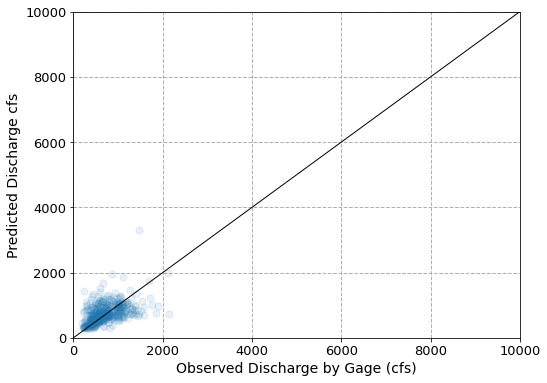

In [78]:
import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,10000], [0, 10000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,10000)
ax.set_xlim(0,10000)

In [79]:
comp = pd.DataFrame()
comp['test_data'] = y_test
comp['predicted'] = predictions
comp['date_col'] = comp.index
comp = comp.sort_values(by=['date_col'])

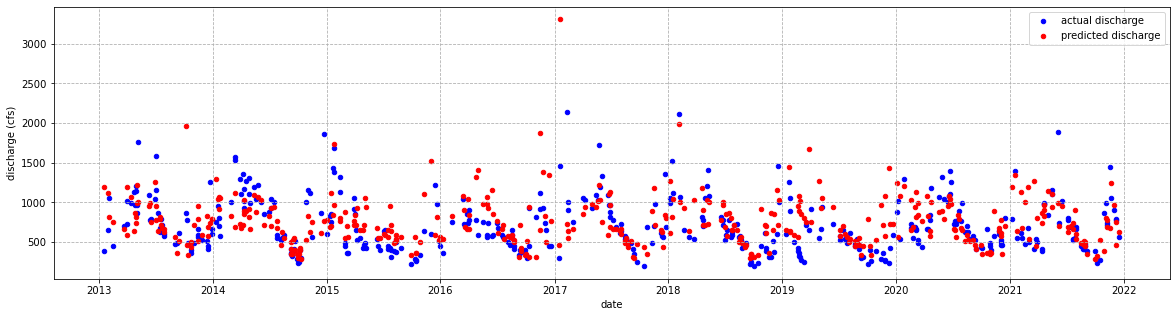

In [80]:
# Plot relationship
ax = comp.plot(kind="scatter", x="date_col",y="test_data", color="b", label="actual discharge", figsize=(20,5))
comp.plot(kind="scatter", x="date_col",y="predicted", color="r", label="predicted discharge", ax=ax)

ax.set_xlabel("date")
ax.set_ylabel("discharge (cfs)")
plt.grid(linestyle='--')
plt.show()

## Removing outliers

### Paradise climate station

In [81]:
q_low = df_cleaned["Nisqually Discharge"].quantile(0.05)
q_hi  = df_cleaned["Nisqually Discharge"].quantile(0.95)

paradise_filtered = df_cleaned[(df_cleaned["Nisqually Discharge"] < q_hi) & (df_cleaned["Nisqually Discharge"] > q_low)]

In [82]:
# Define feature list
feature_list =  paradise_filtered.columns.to_list()

In [83]:
# Compute correlation matrix
corr_matrix = paradise_filtered.corr()

# Display just house value correlations
corr_matrix["Nisqually Discharge"].sort_values(ascending= False)

Nisqually Discharge                                                   1.000000
Depth Soil Moisture                                                   0.405190
Surface Soil Moisture                                                 0.327559
Paradise (679) Air Temperature Minimum (degF)                         0.237941
Paradise (679) Air Temperature Average (degF)                         0.228453
Paradise (679) Snow Density (pct) Start of Day Values                 0.172675
Paradise (679) Air Temperature Maximum (degF)                         0.170488
Paradise (679) Precipitation Accumulation (in) Start of Day Values    0.166318
Paradise (679) Snow Water Equivalent (in) Start of Day Values         0.161732
Paradise (679) Precipitation Increment (in)                           0.141411
Paradise (679) Precipitation Increment - Snow-adj (in)                0.113465
Paradise (679) Snow Depth (in) Start of Day Values                    0.081029
month                                               

In [84]:
# Define features and labels 
X = paradise_filtered[feature_list]
y = paradise_filtered['Nisqually Discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [85]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [86]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [87]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

2.510502232122067

(0.0, 10000.0)

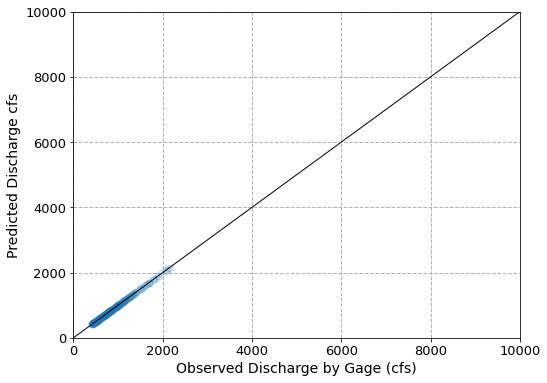

In [88]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,10000], [0, 10000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,10000)
ax.set_xlim(0,10000)

### Daymet

In [89]:
q_low = daymet_cleaned["nisqually_discharge"].quantile(0.05)
q_hi  = daymet_cleaned["nisqually_discharge"].quantile(0.95)

daymet_filtered = daymet_cleaned[(daymet_cleaned["nisqually_discharge"] < q_hi) & (daymet_cleaned["nisqually_discharge"] > q_low)]

In [90]:
daymet_filtered

,prec_data,swe_data,tmax_data,tmin_data,nisqually_discharge,month
date,,,,,,
2013-01-02,0.000000,86.364815,1.876875,-6.503580,413.0,1
2013-01-03,0.000000,85.462469,4.701358,-3.813457,404.0,1
2013-01-04,11.757654,84.381481,4.614568,-3.379877,423.0,1
2013-01-05,7.507901,82.577037,2.696420,-1.602469,426.0,1
2013-01-06,11.034198,81.034321,1.551852,-2.218889,425.0,1
...,...,...,...,...,...,...
2018-12-28,7.342593,145.481358,-1.446420,-5.261358,635.0,12
2018-12-29,29.758889,152.221852,0.955309,-5.120123,1010.0,12
2018-12-30,32.924568,152.353951,1.851481,-2.797901,1500.0,12


In [91]:
# Define feature list
feature_list =  ['prec_data', 'swe_data', 'tmax_data', 'tmin_data', 'month']

In [92]:
# Compute correlation matrix
corr_matrix = daymet_filtered.corr()

# Display just house value correlations
corr_matrix["nisqually_discharge"].sort_values(ascending= False)

nisqually_discharge    1.000000
swe_data               0.368879
prec_data              0.348757
tmin_data             -0.120995
tmax_data             -0.154584
month                 -0.205502
Name: nisqually_discharge, dtype: float64

In [93]:
X = daymet_filtered[feature_list]
y = daymet_filtered['nisqually_discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [94]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [95]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [96]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

203.7087904549763

(0.0, 10000.0)

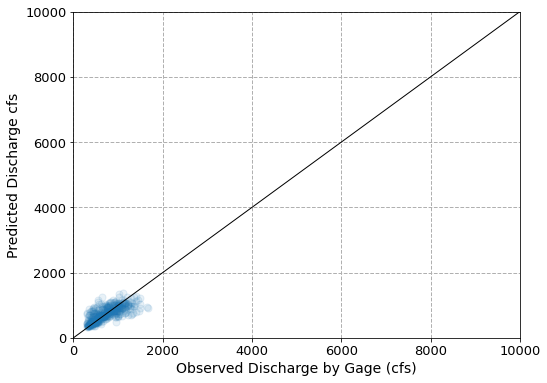

In [97]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,10000], [0, 10000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,10000)
ax.set_xlim(0,10000)

### Satellite

In [98]:
q_low = satellite_cleaned["nisqually_discharge"].quantile(0.05)
q_hi  = satellite_cleaned["nisqually_discharge"].quantile(0.95)

satellite_filtered = satellite_cleaned[(satellite_cleaned["nisqually_discharge"] < q_hi) & (satellite_cleaned["nisqually_discharge"] > q_low)]

In [99]:
satellite_filtered

,snow,temp,prec,nisqually_discharge,month
date,,,,,
2013-01-01,56.669666,31.283200,25.122626,424.0,1
2013-01-02,52.070299,34.500663,0.235298,413.0,1
2013-01-03,51.463661,34.984130,0.010412,404.0,1
2013-01-04,65.101677,25.856654,11.616317,423.0,1
2013-01-06,39.286975,34.226659,3.846788,425.0,1
...,...,...,...,...,...
2021-12-24,50.053224,21.695956,75.993609,971.0,12
2021-12-27,42.476682,1.240611,45.353518,656.0,12
2021-12-29,61.435763,4.933996,0.726814,567.0,12


In [100]:
feature_list =  ['snow', 'temp', 'prec', 'month']

In [101]:
# Define features and labels 
X = satellite_filtered[feature_list]
y = satellite_filtered['nisqually_discharge']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [102]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [103]:
from sklearn.ensemble import RandomForestRegressor

# Define model
forest_reg = RandomForestRegressor(n_estimators = 100)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [104]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

241.68867864969576

(0.0, 10000.0)

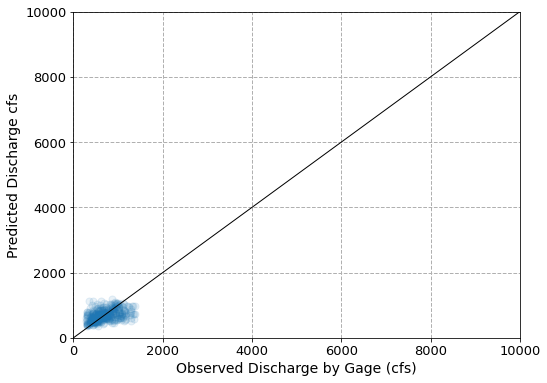

In [105]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,10000], [0, 10000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted Discharge cfs', fontsize=14)
ax.set_xlabel('Observed Discharge by Gage (cfs)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,10000)
ax.set_xlim(0,10000)